In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

url_emissions = 'https://raw.githubusercontent.com/janzika/MATH3041/618718923297ec99e11cd3cd25af5ba1173d4a33/data/annual-co-emissions-by-region.csv'
emission_data = pd.read_csv(url_emissions)

url_gdp = 'https://raw.githubusercontent.com/janzika/MATH3041/618718923297ec99e11cd3cd25af5ba1173d4a33/data/gdp-per-capita-maddison-2020.csv'
gdp_data = pd.read_csv(url_gdp)
world_emission_values = np.where(emission_data['Entity']== 'World')[0]
emission_world = emission_data['Annual CO₂ emissions (zero filled)'][world_emission_values[0]:world_emission_values[-1]]
world_gdp_values = np.where(gdp_data['Entity']== 'World')[0]
gdp_world = gdp_data['GDP per capita'][world_emission_values[0]:world_emission_values[-1]]

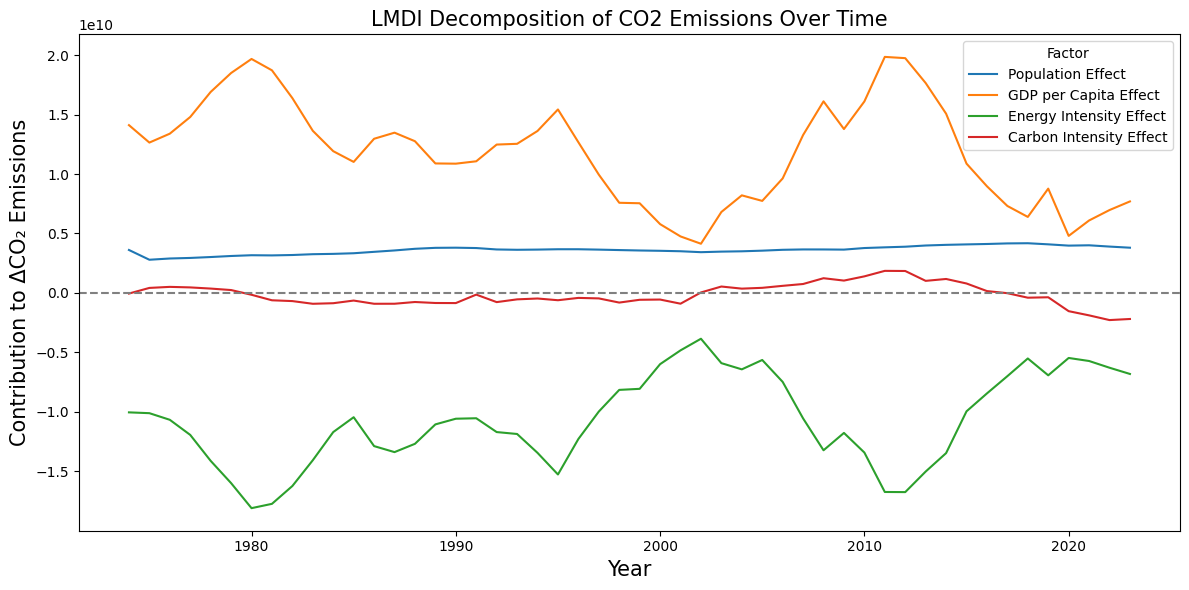

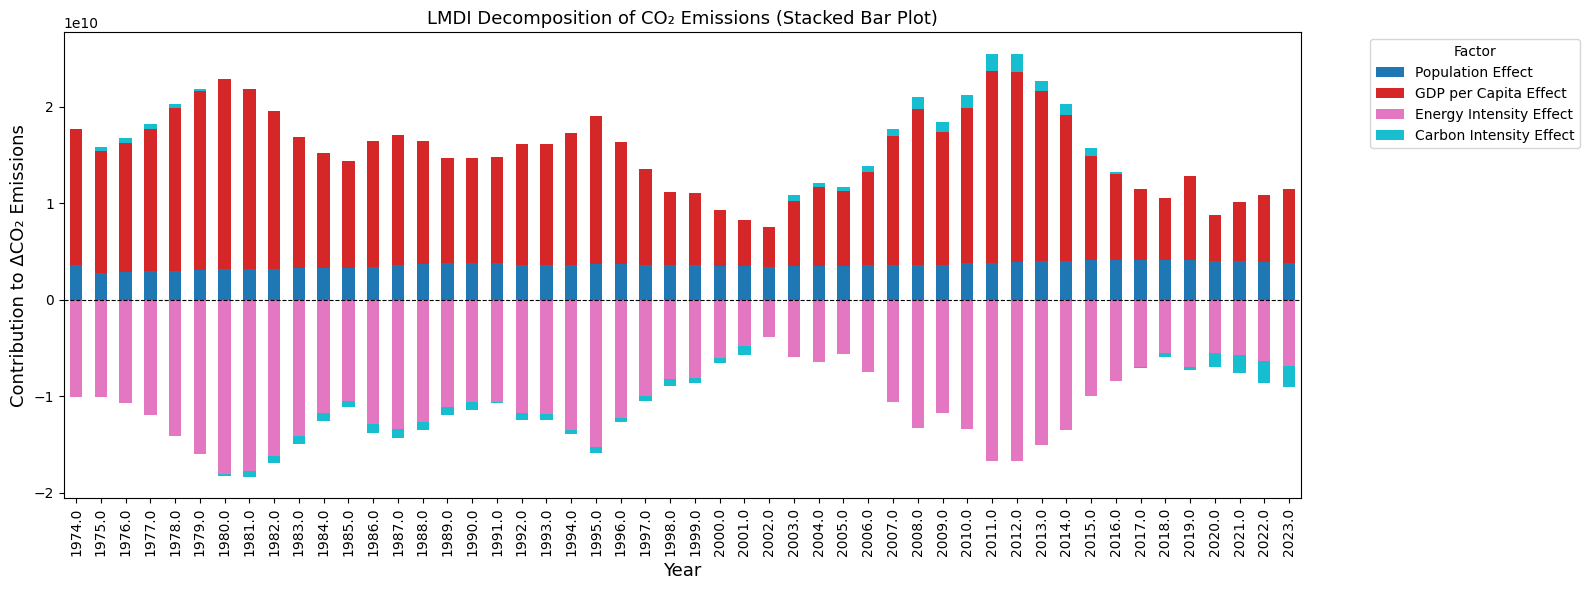

GDP: 0.05893425507003047 energy_intensity: -0.047888442039685564 carbon_intensity -0.0013132550312531244 population: 0.016871025955770724


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Load the CSVs ===
gdp_df = pd.read_csv("API_NY.GDP.PCAP.CD_DS2_en_csv_v2_122367.csv", skiprows=4)
population_df = pd.read_csv("population.csv")
energy_df = pd.read_csv("global-energy-substitution.csv")
co2_df = pd.read_csv("annual-co2-emissions-per-country.csv")


# === 2. Filter for World and select required columns ===
gdp_df = gdp_df[
    (gdp_df['Country Name'] == 'World') &
    (gdp_df['Indicator Name'] == 'GDP per capita (current US$)')
]
gdp_df = gdp_df.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
gdp_df = gdp_df.melt(var_name='Year', value_name='GDP_per_capita')
gdp_df['Year'] = pd.to_numeric(gdp_df['Year'], errors='coerce')
gdp_df['GDP_per_capita'] = pd.to_numeric(gdp_df['GDP_per_capita'], errors='coerce')
gdp_df = gdp_df.dropna()
gdp_df = gdp_df[gdp_df['Year'] >= 1960].sort_values('Year')

population_df = population_df[population_df['Entity'] == 'World'][['Year', 'Population (historical)']]
energy_columns = [
    'Other renewables (TWh, substituted energy)',
    'Biofuels (TWh, substituted energy)',
    'Solar (TWh, substituted energy)',
    'Wind (TWh, substituted energy)',
    'Hydropower (TWh, substituted energy)',
    'Nuclear (TWh, substituted energy)',
    'Gas (TWh, substituted energy)',
    'Oil (TWh, substituted energy)',
    'Coal (TWh, substituted energy)',
    'Traditional biomass (TWh, substituted energy)'
]
energy_world = energy_df[energy_df['Entity'] == 'World'].copy()
energy_world['Total Energy (TWh)'] = energy_world[energy_columns].sum(axis=1)
energy_world[['Year', 'Total Energy (TWh)']].head()
co2_df = co2_df[co2_df['Entity'] == 'World'][['Year', 'Annual CO₂ emissions']]

# === 3. Merge datasets on Year (use fixed energy df!) ===
df = gdp_df.merge(population_df, on='Year') \
           .merge(energy_world[['Year', 'Total Energy (TWh)']], on='Year') \
           .merge(co2_df, on='Year')

# === 4. Rename columns ===
df = df.rename(columns={
    'Gross domestic product (GDP)': 'GDP',
    'Population (historical)': 'Population',
    'Total Energy (TWh)': 'Energy',
    'Annual CO₂ emissions': 'CO2'
})

# === 4. Log mean function ===
def log_mean(x, y):
    if x == y:
        return x
    else:
        return (x - y) / (np.log(x) - np.log(y))

# === 5. LMDI decomposition over time ===
results = {
    'Year': [],
    'Population Effect': [],
    'GDP per Capita Effect': [],
    'Energy Intensity Effect': [],
    'Carbon Intensity Effect': [],
    'Total CO2 Change': []
}
df = df.replace(0, np.nan).dropna()

# === 6. Compute Kaya components ===
df['GDP'] = df['GDP_per_capita'] * df['Population']
df['GDP_per_capita'] = df['GDP'] / df['Population']
df['Energy_intensity'] = df['Energy'] / df['GDP']
df['Carbon_intensity'] = df['CO2'] / df['Energy']
df = df[df['Year'] >= 1930]

# === 7. LMDI year-over-year contributions ===
for i in range(10, len(df)):
    year = df['Year'].iloc[i]

    # Variables for this year and previous year
    pop1, pop0 = df['Population'].iloc[i], df['Population'].iloc[i - 10]
    gdp_pc1, gdp_pc0 = df['GDP_per_capita'].iloc[i], df['GDP_per_capita'].iloc[i - 10]
    ei1, ei0 = df['Energy_intensity'].iloc[i], df['Energy_intensity'].iloc[i - 10]
    ci1, ci0 = df['Carbon_intensity'].iloc[i], df['Carbon_intensity'].iloc[i - 10]
    co2_1, co2_0 = df['CO2'].iloc[i], df['CO2'].iloc[i - 10]

    # Log mean weighting
    L = log_mean(co2_1, co2_0)

    # Contributions
    pop_effect = L * np.log(pop1 / pop0)
    gdp_pc_effect = L * np.log(gdp_pc1 / gdp_pc0)
    ei_effect = L * np.log(ei1 / ei0)
    ci_effect = L * np.log(ci1 / ci0)
    total_change = co2_1 - co2_0

    # Append to results
    results['Year'].append(year)
    results['Population Effect'].append(pop_effect)
    results['GDP per Capita Effect'].append(gdp_pc_effect)
    results['Energy Intensity Effect'].append(ei_effect)
    results['Carbon Intensity Effect'].append(ci_effect)
    results['Total CO2 Change'].append(total_change)

# === 8. Create a results DataFrame ===
lmdi_df = pd.DataFrame(results)

# === 9. Plotting each effect over time ===
plt.figure(figsize=(12, 6))
sns.lineplot(data=lmdi_df.melt(id_vars='Year',
                               value_vars=['Population Effect', 'GDP per Capita Effect',
                                           'Energy Intensity Effect', 'Carbon Intensity Effect']),
             x='Year', y='value', hue='variable')
plt.axhline(0, color='gray', linestyle='--')
plt.title('LMDI Decomposition of CO2 Emissions Over Time', fontsize=15)
plt.ylabel('Contribution to ΔCO₂ Emissions', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.legend(title='Factor')
plt.tight_layout()
plt.show()

# === 10. Stacked bar plot ===
bar_df = lmdi_df.set_index('Year')[[
    'Population Effect',
    'GDP per Capita Effect',
    'Energy Intensity Effect',
    'Carbon Intensity Effect'
]]

# Plot
bar_df.plot(kind='bar', stacked=True, figsize=(16, 6), colormap='tab10')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('LMDI Decomposition of CO₂ Emissions (Stacked Bar Plot)', fontsize=13)
plt.ylabel('Contribution to ΔCO₂ Emissions', fontsize=13)
plt.xlabel('Year', fontsize=13)
plt.legend(title='Factor', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

def compute_r(series):
    start = series.iloc[0]
    end = series.iloc[-1]
    t = len(series) - 1
    return (end / start)**(1 / t) - 1

r_gdp = compute_r(df['GDP_per_capita'])
r_ei = compute_r(df['Energy_intensity'])  # this should be negative
r_ci = compute_r(df['Carbon_intensity'])  # this is the variable
r_pop = compute_r(df['Population'])
print("GDP:", r_gdp, "energy_intensity:", r_ei, "carbon_intensity", r_ci, "population:", r_pop)

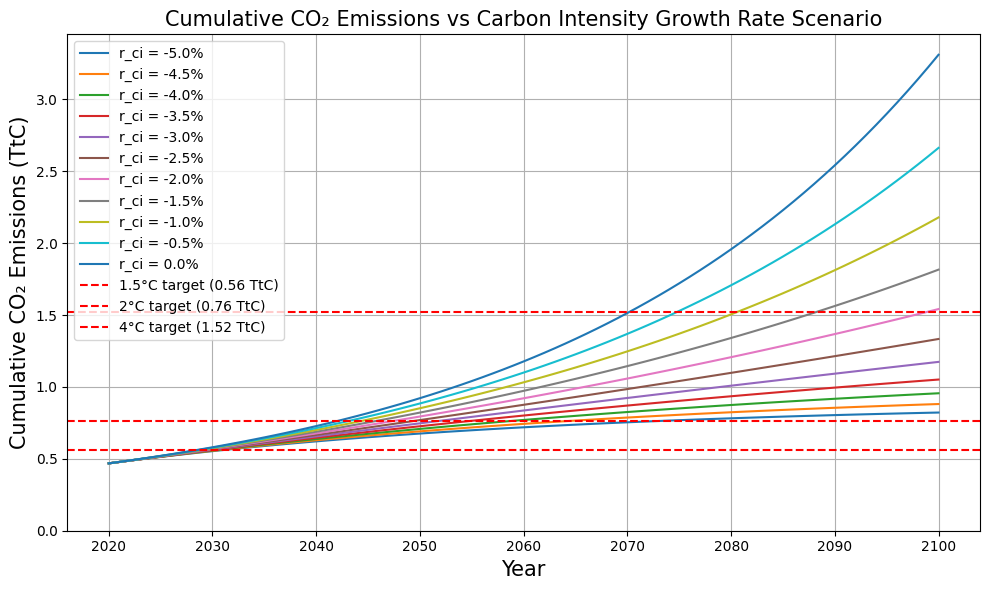

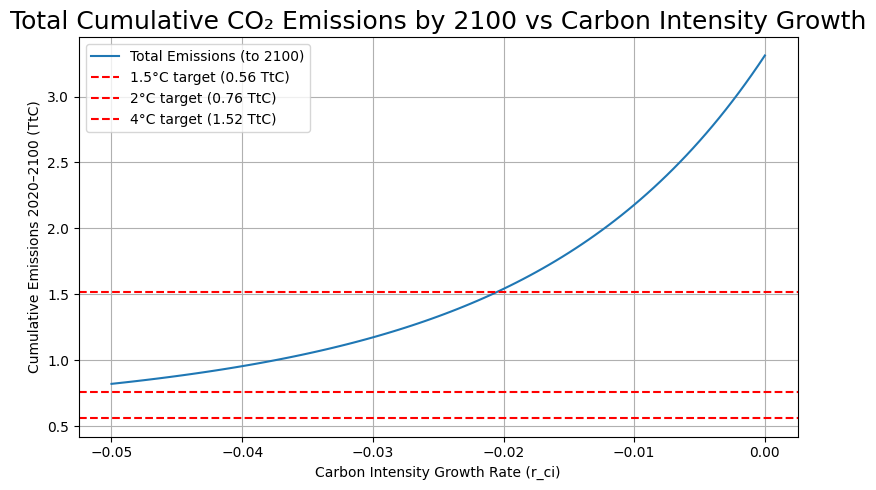

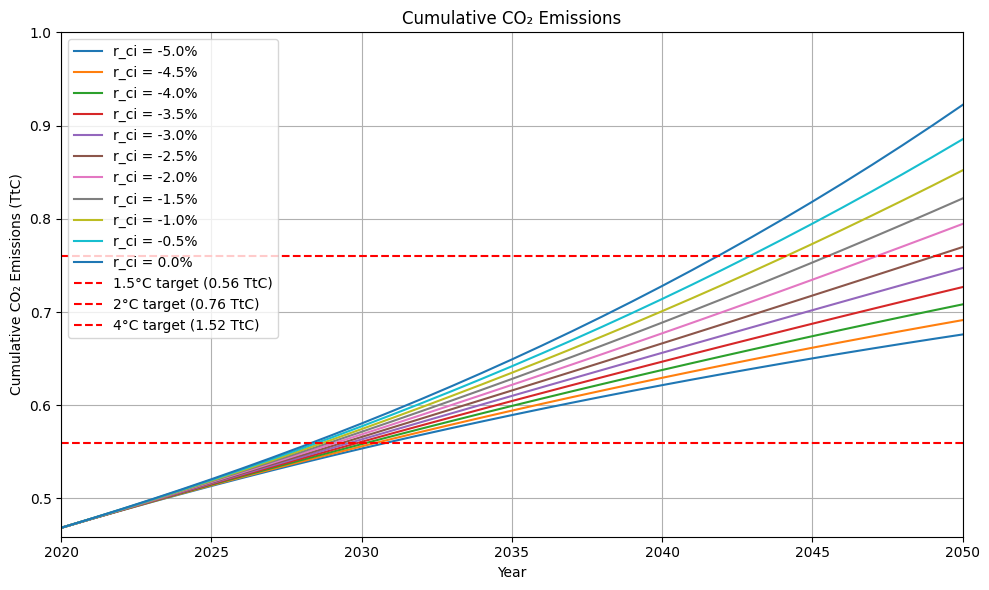

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# === Known average r values from your decomposition ===

# === Initial emissions in TtC (2023 value: 35.13 GtCO2)
# 1 GtCO₂ = 0.273 TtC
C0_TtC = 35126526000 * 0.273 / 1e12  # 0.0096 TtC/yr
t_years = 80
r_ci_range = np.linspace(-0.05, 0.00, 101)
years = np.arange(2020, 2021 + t_years)
BASELINE_TtC = 0.459

# === Store results
final_cumulative = []
trajectories = []
for r_ci in r_ci_range:
    annual_emissions = []

    for i, year in enumerate(years):
        t = i
        if year <= 2100:
            r_dynamic = r_ci
        else:
            # After 2070, r_ci has doubled
            r_dynamic = r_ci * 2

        r_total = r_gdp + r_pop + r_ei + r_dynamic

        if t == 0:
            emission = C0_TtC
        else:
            emission = annual_emissions[-1] * (1 + r_total)

        annual_emissions.append(emission)

    cumulative_emissions = BASELINE_TtC + np.cumsum(annual_emissions)
    final_cumulative.append(cumulative_emissions[-1])
    trajectories.append(cumulative_emissions)


# === Plot cumulative emissions over time
plt.figure(figsize=(10, 6))
for i in range(0, len(trajectories), 10):
    plt.plot(years, trajectories[i], label=f"r_ci = {r_ci_range[i]*100:.1f}%")

# === Climate targets (in TtC)
targets = {
    "1.5°C target (0.56 TtC)": 0.56,
    "2°C target (0.76 TtC)": 0.76,
    "4°C target (1.52 TtC)": 1.52
}
for label, value in targets.items():
    plt.axhline(y=value, color='red', linestyle='--', label=label)

plt.title("Cumulative CO₂ Emissions vs Carbon Intensity Growth Rate Scenario", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Cumulative CO₂ Emissions (TtC)", fontsize=15)
plt.legend()
plt.ylim(bottom=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot final cumulative emissions in 2100 vs r_ci
plt.figure(figsize=(8, 5))
plt.plot(r_ci_range, final_cumulative, label="Total Emissions (to 2100)")
for label, value in targets.items():
    plt.axhline(y=value, color='red', linestyle='--', label=label)

plt.title("Total Cumulative CO₂ Emissions by 2100 vs Carbon Intensity Growth", fontsize=18)
plt.xlabel("Carbon Intensity Growth Rate (r_ci)")
plt.ylabel("Cumulative Emissions 2020–2100 (TtC)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Zoomed-in plot: 2020–2050 ===
plt.figure(figsize=(10, 6))
for i in range(0, len(trajectories), 10):
    plt.plot(years, trajectories[i], label=f"r_ci = {r_ci_range[i]*100:.1f}%")

for label, value in targets.items():
    plt.axhline(y=value, color='red', linestyle='--', label=label)

plt.title("Cumulative CO₂ Emissions")
plt.xlabel("Year")
plt.ylabel("Cumulative CO₂ Emissions (TtC)")
plt.xlim(2020, 2050)     # Focus on the 2020–2050 range
plt.ylim(0.459, 1.0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [41]:
import numpy as np

# ---- Inputs to control ----
C0_TtC = 35126526000 * 0.273 / 1e12   # 2023 annual emissions in TtC/yr ≈ 0.00959
BASELINE_TtC = 0.459                   # cumulative up to start year (your choice)
start_year, end_year = 2020, 2100
target_TtC = 0.56                      # smallest budget (1.5°C)
hit_year = 2100                        # solve to hit target by this year
r_other = 0.0                          # <-- set to (r_gdp + r_pop + r_ei) average
double_after = None                    # e.g., 2070 if you want r_ci doubled after that
double_factor = 2.0

years = np.arange(start_year, end_year + 1)

def simulate_final_cum(r_ci):
    annual = []
    for i, y in enumerate(years):
        if double_after is not None and y > double_after:
            r_dynamic = r_ci * double_factor
        else:
            r_dynamic = r_ci

        r_total = r_other + r_dynamic
        if i == 0:
            e = C0_TtC
        else:
            e = annual[-1] * (1 + r_total)
        annual.append(e)

    cum = BASELINE_TtC + np.cumsum(annual)
    # value at 'hit_year'
    idx = np.where(years == hit_year)[0][0]
    return cum[idx]

# ---- Solve r_ci via bisection ----
def solve_rci_for_target(low=-0.20, high=0.10, tol=1e-8, maxit=200):
    f_low = simulate_final_cum(low) - target_TtC
    f_high = simulate_final_cum(high) - target_TtC
    if f_low * f_high > 0:
        raise ValueError("Target not bracketed; adjust low/high or inputs.")

    for _ in range(maxit):
        mid = 0.5 * (low + high)
        f_mid = simulate_final_cum(mid) - target_TtC
        if abs(f_mid) < tol:
            return mid
        if f_low * f_mid <= 0:
            high, f_high = mid, f_mid
        else:
            low, f_low = mid, f_mid
    return 0.5 * (low + high)

r_ci_star = solve_rci_for_target()
print(f"r_ci that hits {target_TtC:.2f} TtC by {hit_year}: {r_ci_star:.8f}  (~{r_ci_star*100:.4f}%)")


r_ci that hits 0.56 TtC by 2100: -0.09491649  (~-9.4916%)


# Data Graphing




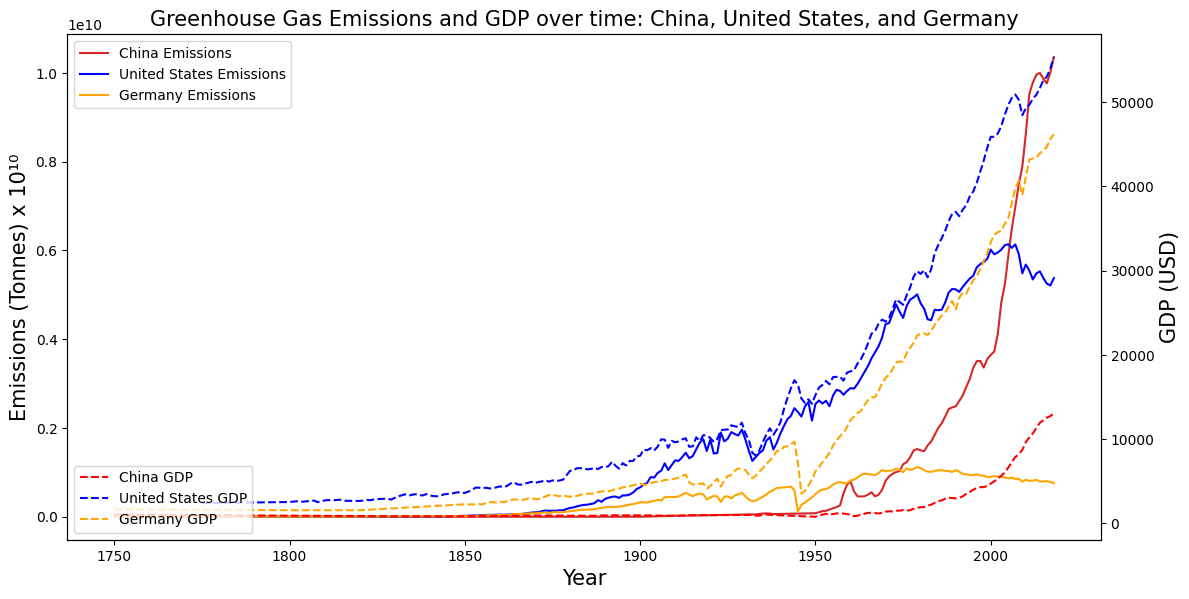

In [43]:
# Emissions
china_emissions_values = np.where(emission_data['Entity']== 'China')[0]
china_emissions = emission_data['Annual CO₂ emissions (zero filled)'][china_emissions_values[0]:china_emissions_values[-1]]
us_emissions_values = np.where(emission_data['Entity']== 'United States')[0]
us_emissions = emission_data['Annual CO₂ emissions (zero filled)'][us_emissions_values[0]:us_emissions_values[-1]]
germany_emissions_values = np.where(emission_data['Entity']== 'Germany')[0]
germany_emissions = emission_data['Annual CO₂ emissions (zero filled)'][germany_emissions_values[0]:germany_emissions_values[-1]]
# ---------

# GDP
china_gdp_values = np.where(gdp_data['Entity']== 'China')[0]
china_gdp = gdp_data['GDP per capita'][china_gdp_values[0]:china_gdp_values[-1]]
us_gdp_values =np.where(gdp_data['Entity']== 'United States')[0]
us_gdp = gdp_data['GDP per capita'][us_gdp_values[0]:us_gdp_values[-1]]
germany_gdp_values = np.where(gdp_data['Entity']== 'Germany')[0]
germany_gdp = gdp_data['GDP per capita'][germany_gdp_values[0]:germany_gdp_values[-1]]

# ---------

# Merge dataframes on 'Year' and 'Entity'
merged_data = pd.merge(emission_data, gdp_data, on=['Year', 'Entity'], how='inner')

# Filter data for the desired countries
china_data = merged_data[merged_data['Entity'] == 'China']
us_data = merged_data[merged_data['Entity'] == 'United States']
germany_data = merged_data[merged_data['Entity'] == 'Germany']

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Year', fontsize=15)
ax1.set_ylabel('Emissions (Tonnes) x 10¹⁰', fontsize=15)
ax1.plot(china_data['Year'], china_data['Annual CO₂ emissions (zero filled)'], label='China Emissions', color=color)
ax1.plot(us_data['Year'], us_data['Annual CO₂ emissions (zero filled)'], label='United States Emissions', color='blue')
ax1.plot(germany_data['Year'], germany_data['Annual CO₂ emissions (zero filled)'], label='Germany Emissions', color='orange')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')


ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('GDP (USD)', fontsize=15)
ax2.plot(china_data['Year'], china_data['GDP per capita'], label='China GDP', color='red', linestyle='dashed')
ax2.plot(us_data['Year'], us_data['GDP per capita'], label='United States GDP', color='blue', linestyle='dashed')
ax2.plot(germany_data['Year'], germany_data['GDP per capita'], label='Germany GDP', color='orange', linestyle='dashed')
ax2.tick_params(axis='y')
ax2.legend(loc='lower left')


fig.tight_layout()

plt.title('Greenhouse Gas Emissions and GDP over time: China, United States, and Germany', fontsize=15)
plt.show()

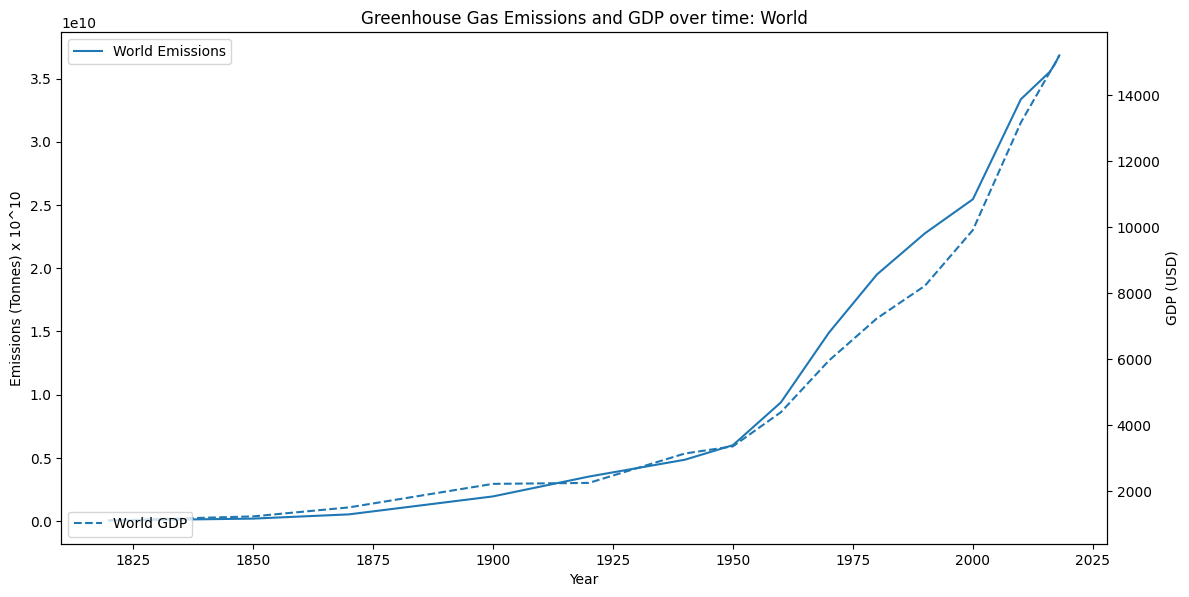

In [44]:
# Collect emission data for World
world_emission_values = np.where(emission_data['Entity']== 'World')[0]
emission_world = emission_data['Annual CO₂ emissions (zero filled)'][world_emission_values[0]:world_emission_values[-1] + 1] # Include the last index
world_emission_years = emission_data['Year'][world_emission_values[0]:world_emission_values[-1] + 1]

# Collect GDP data for World
world_gdp_values = np.where(gdp_data['Entity']== 'World')[0]
gdp_world = gdp_data['GDP per capita'][world_gdp_values[0]:world_gdp_values[-1] + 1] # Correct index range for gdp_data
world_gdp_years = gdp_data['Year'][world_gdp_values[0]:world_gdp_values[-1] + 1]

# Align dataframes on 'Year'
world_emissions_df = pd.DataFrame({'Year': world_emission_years, 'Emissions': emission_world})
world_gdp_df = pd.DataFrame({'Year': world_gdp_years, 'GDP': gdp_world})

# Merge the data to fit properly
merged_world_data = pd.merge(world_emissions_df, world_gdp_df, on='Year', how='inner')

# Create axis 1
fig, ax1 = plt.subplots(figsize=(12, 6))

# Set left Y axis to the emission values
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Emissions (Tonnes) x 10^10')
ax1.plot(merged_world_data['Year'], merged_world_data['Emissions'], label='World Emissions')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

# Create axis 2 and set right Y axis to be GDP
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('GDP (USD)')
ax2.plot(merged_world_data['Year'], merged_world_data['GDP'], label='World GDP', linestyle='dashed')
ax2.tick_params(axis='y')
ax2.legend(loc='lower left')

fig.tight_layout()

plt.title('Greenhouse Gas Emissions and GDP over time: World')
plt.show()

/tmp/ipython-input-1707290250.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0, 0].legend()
/tmp/ipython-input-1707290250.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1, 0].legend()


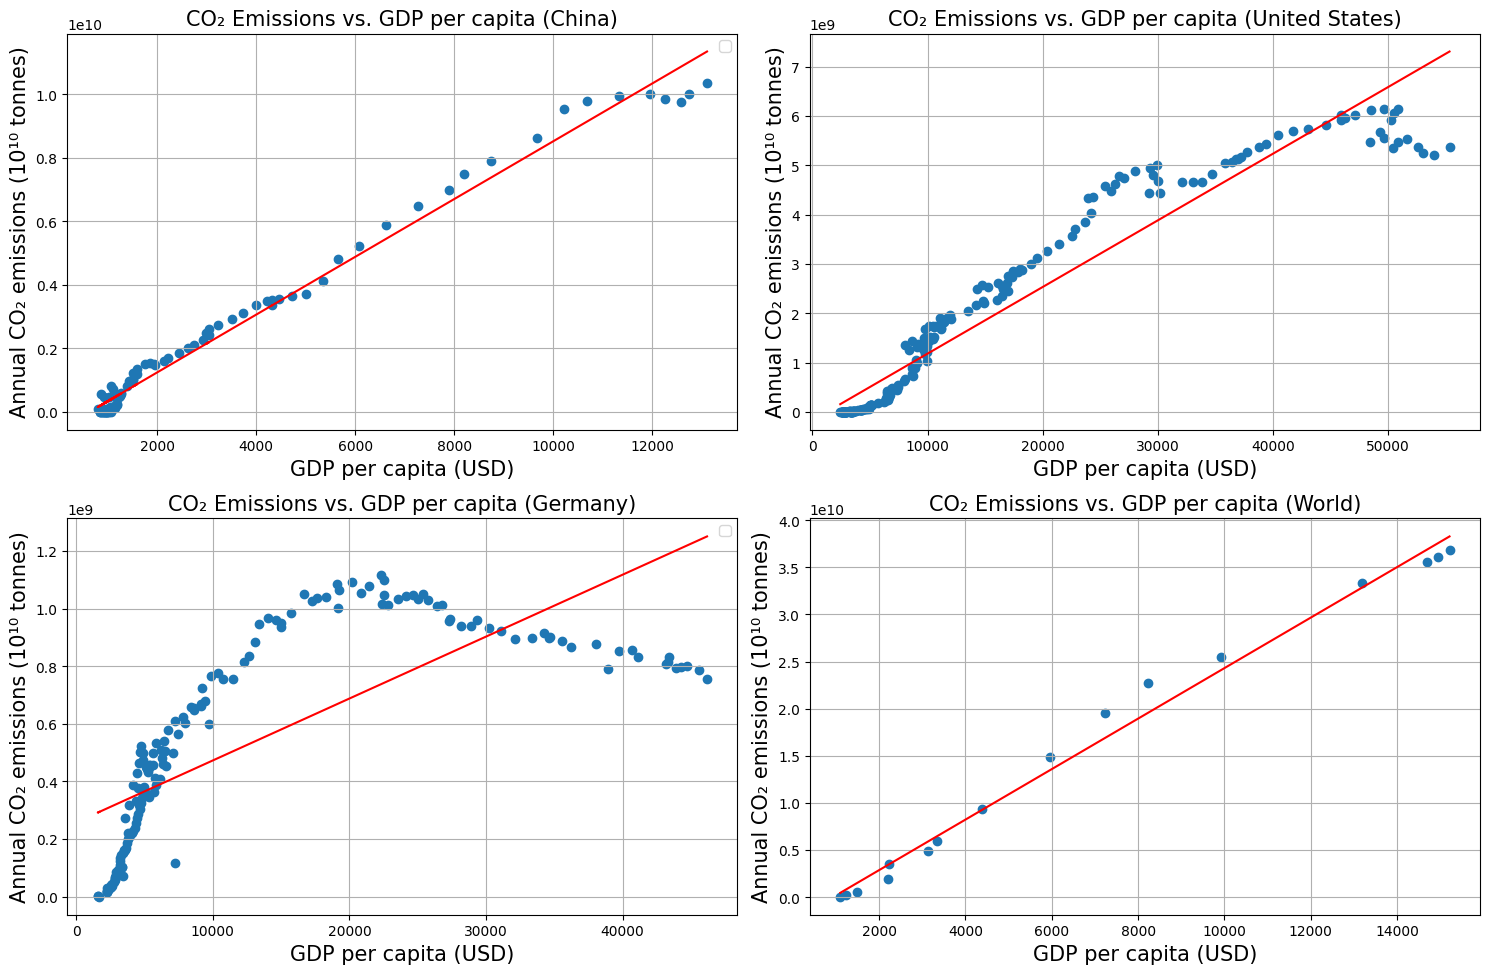

In [45]:
merged_china_data = merged_data[merged_data['Entity'] == 'China']
merged_us_data = merged_data[merged_data['Entity'] == 'United States']
merged_germany_data = merged_data[merged_data['Entity'] == 'Germany']
merged_world_data = merged_data[merged_data['Entity'] == 'World']

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# China
china_model_linear_coeffs = np.polyfit(merged_china_data['GDP per capita'], merged_china_data['Annual CO₂ emissions (zero filled)'], 1)
y_pred = np.polyval(china_model_linear_coeffs, merged_china_data['GDP per capita'])

axs[0, 0].scatter(merged_china_data['GDP per capita'], merged_china_data['Annual CO₂ emissions (zero filled)'])
axs[0, 0].set_xlabel('GDP per capita (USD)', fontsize=15)
axs[0, 0].set_ylabel('Annual CO₂ emissions (10¹⁰ tonnes)', fontsize=15)
axs[0, 0].set_title('CO₂ Emissions vs. GDP per capita (China)', fontsize=15)
axs[0, 0].grid(True)
axs[0, 0].plot(merged_china_data['GDP per capita'], y_pred, color='red')
axs[0, 0].legend()

# USA
us_model_linear_coeffs = np.polyfit(merged_us_data['GDP per capita'], merged_us_data['Annual CO₂ emissions (zero filled)'], 1)
y_pred = np.polyval(us_model_linear_coeffs, merged_us_data['GDP per capita'])

axs[0, 1].scatter(merged_us_data['GDP per capita'], merged_us_data['Annual CO₂ emissions (zero filled)'])
axs[0, 1].set_xlabel('GDP per capita (USD)', fontsize=15)
axs[0, 1].set_ylabel('Annual CO₂ emissions (10¹⁰ tonnes)', fontsize=15)
axs[0, 1].set_title('CO₂ Emissions vs. GDP per capita (United States)', fontsize=15)
axs[0, 1].grid(True)
axs[0, 1].plot(merged_us_data['GDP per capita'], y_pred, color='red')

# Germany
germany_model_linear_coeffs = np.polyfit(merged_germany_data['GDP per capita'], merged_germany_data['Annual CO₂ emissions (zero filled)'], 1)
y_pred = np.polyval(germany_model_linear_coeffs, merged_germany_data['GDP per capita'])

axs[1, 0].scatter(merged_germany_data['GDP per capita'], merged_germany_data['Annual CO₂ emissions (zero filled)'])
axs[1, 0].set_xlabel('GDP per capita (USD)', fontsize=15)
axs[1, 0].set_ylabel('Annual CO₂ emissions (10¹⁰ tonnes)', fontsize=15)
axs[1, 0].set_title('CO₂ Emissions vs. GDP per capita (Germany)', fontsize=15)
axs[1, 0].grid(True)
axs[1, 0].plot(merged_germany_data['GDP per capita'], y_pred, color='red')
axs[1, 0].legend()

# World
world_model_linear_coeffs = np.polyfit(merged_world_data['GDP per capita'], merged_world_data['Annual CO₂ emissions (zero filled)'], 1)
y_pred = np.polyval(world_model_linear_coeffs, merged_world_data['GDP per capita'])

axs[1, 1].scatter(merged_world_data['GDP per capita'], merged_world_data['Annual CO₂ emissions (zero filled)'])
axs[1, 1].set_xlabel('GDP per capita (USD)', fontsize=15)
axs[1, 1].set_ylabel('Annual CO₂ emissions (10¹⁰ tonnes)', fontsize=15)
axs[1, 1].set_title('CO₂ Emissions vs. GDP per capita (World)', fontsize=15)
axs[1, 1].grid(True)
axs[1, 1].plot(merged_world_data['GDP per capita'], y_pred, color='red')

plt.tight_layout()
plt.show()